# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

In [1]:
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.07KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

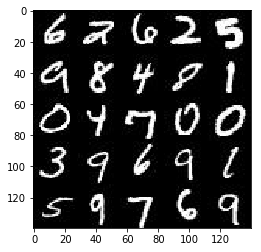

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

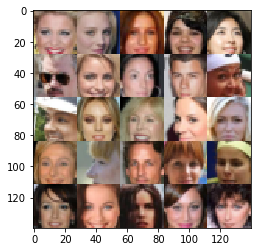

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,(None), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha * x1, x1)
        # Output layer is 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # Output layer is 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # Output layer is 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer - input (z_dim)
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # Out: 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # Out: 14x14x256
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # Out: 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    gen_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                    labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every=10
    show_every=100
    
    
    image_width, image_height, image_channels = [dim for dim in data_shape[1:]]
    
    #Get the placeholders
    input_real, input_z, learning_r = model_inputs(image_width, image_height, image_channels, z_dim)
    
    #get the losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    #get the optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
            
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model   
                batch_images *= 2
                step += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,learning_r:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,learning_r:learning_rate})
                # Optiimize Generator twice to keep the loss from going to zero
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,learning_r:learning_rate})
                
                # Show output every show_every batches
                if step % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
               
                # At the end of print_every batches, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                if step % print_every == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    
        #Show a bigger output at the end         
        show_generator_output(sess, 15, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.
_Make sure the loss of the generator is lower than the loss of the discriminator or close to 0._  


Epoch 1/2... Discriminator Loss: 4.2108... Generator Loss: 0.0320
Epoch 1/2... Discriminator Loss: 3.2303... Generator Loss: 0.0743
Epoch 1/2... Discriminator Loss: 2.4463... Generator Loss: 0.2179
Epoch 1/2... Discriminator Loss: 2.3217... Generator Loss: 0.4533
Epoch 1/2... Discriminator Loss: 2.0328... Generator Loss: 0.3027
Epoch 1/2... Discriminator Loss: 2.0147... Generator Loss: 0.3302
Epoch 1/2... Discriminator Loss: 2.0481... Generator Loss: 0.5596
Epoch 1/2... Discriminator Loss: 1.7267... Generator Loss: 0.3464
Epoch 1/2... Discriminator Loss: 1.4958... Generator Loss: 0.6508


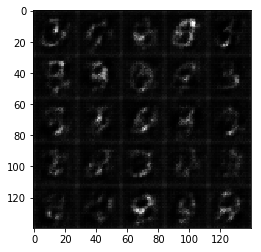

Epoch 1/2... Discriminator Loss: 1.7210... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.6532... Generator Loss: 1.1075
Epoch 1/2... Discriminator Loss: 1.7486... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 1.5178... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 1.6727... Generator Loss: 0.4204
Epoch 1/2... Discriminator Loss: 1.5808... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 1.5265... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 1.3752
Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 1.5156... Generator Loss: 0.4244


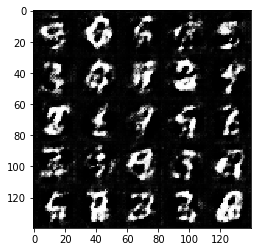

Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.9635
Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 1.0231
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.6830
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 1.2758
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 1.2420
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.5300


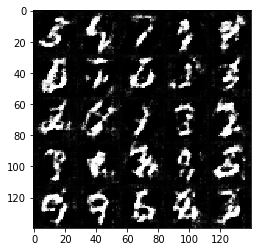

Epoch 1/2... Discriminator Loss: 1.7582... Generator Loss: 0.3017
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.8109... Generator Loss: 0.3259
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 1.6377... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 1.7998... Generator Loss: 0.3106
Epoch 1/2... Discriminator Loss: 1.5408... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.5284
Epoch 1/2... Discriminator Loss: 1.6986... Generator Loss: 0.3432


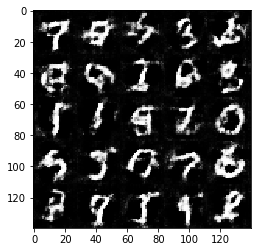

Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 1.6286... Generator Loss: 0.4736
Epoch 1/2... Discriminator Loss: 1.4780... Generator Loss: 0.5147
Epoch 1/2... Discriminator Loss: 1.7427... Generator Loss: 0.5125
Epoch 1/2... Discriminator Loss: 1.6014... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 1.5806... Generator Loss: 0.4235
Epoch 1/2... Discriminator Loss: 1.6522... Generator Loss: 0.3590
Epoch 1/2... Discriminator Loss: 1.9030... Generator Loss: 0.2592
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.6619


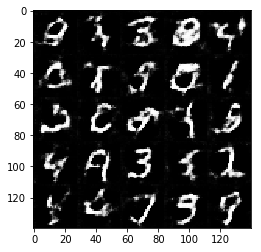

Epoch 1/2... Discriminator Loss: 1.7404... Generator Loss: 0.3717
Epoch 1/2... Discriminator Loss: 1.7899... Generator Loss: 0.3055
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.6789
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 1.1328
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.7455
Epoch 1/2... Discriminator Loss: 1.8423... Generator Loss: 0.2908
Epoch 1/2... Discriminator Loss: 1.5925... Generator Loss: 0.3923
Epoch 1/2... Discriminator Loss: 1.6433... Generator Loss: 1.5915
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.7344


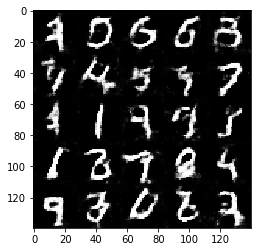

Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.4288
Epoch 1/2... Discriminator Loss: 1.5958... Generator Loss: 0.4106
Epoch 1/2... Discriminator Loss: 1.9798... Generator Loss: 0.2638
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.6884
Epoch 1/2... Discriminator Loss: 1.4529... Generator Loss: 0.5715
Epoch 1/2... Discriminator Loss: 1.5359... Generator Loss: 0.5922
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.5270
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.5959


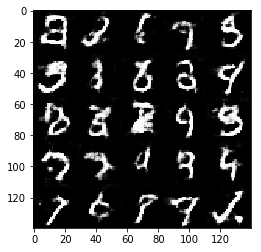

Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.5883
Epoch 1/2... Discriminator Loss: 1.8577... Generator Loss: 0.3219
Epoch 1/2... Discriminator Loss: 1.6595... Generator Loss: 0.3279
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.8111
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.4997
Epoch 1/2... Discriminator Loss: 1.9437... Generator Loss: 0.2530
Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 0.4346
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 1.4110... Generator Loss: 0.5850
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 0.7041


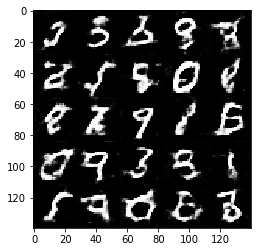

Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 1.2806
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.5759
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.6397
Epoch 1/2... Discriminator Loss: 1.6408... Generator Loss: 0.7174
Epoch 1/2... Discriminator Loss: 1.5455... Generator Loss: 1.5617
Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.4535
Epoch 1/2... Discriminator Loss: 1.7173... Generator Loss: 0.3486
Epoch 1/2... Discriminator Loss: 1.7780... Generator Loss: 0.2950


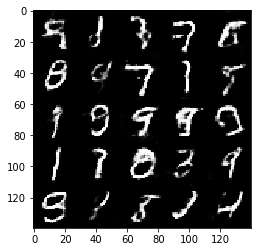

Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 0.5759
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.6712
Epoch 1/2... Discriminator Loss: 1.2320... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.2694... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 0.8136
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.6127... Generator Loss: 0.3951
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.5269


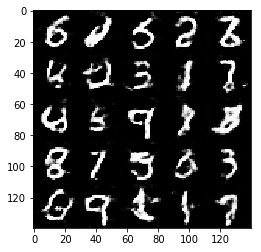

Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.5975... Generator Loss: 0.3863
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 1.4234
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 0.7630
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 1.0725


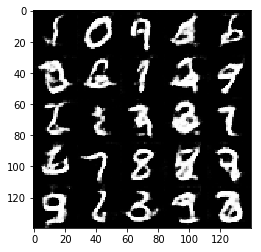

Epoch 1/2... Discriminator Loss: 1.5991... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 1.0348
Epoch 1/2... Discriminator Loss: 1.7565... Generator Loss: 0.3112
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 2.2731... Generator Loss: 0.2122
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 2.0208... Generator Loss: 0.2215
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.8390


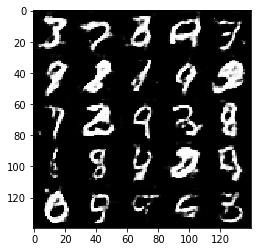

Epoch 1/2... Discriminator Loss: 1.5573... Generator Loss: 0.4025
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.5672... Generator Loss: 0.4170
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.4597
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 1.2770... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 1.4723... Generator Loss: 2.2188
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.6828... Generator Loss: 0.3318
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.5196


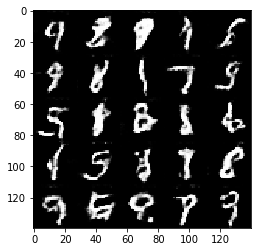

Epoch 1/2... Discriminator Loss: 1.6280... Generator Loss: 0.3749
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.4315
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.4964
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 1.4969
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.5238
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.6796... Generator Loss: 0.3460
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 1.1544
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 0.7803


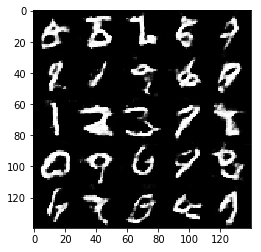

Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 0.6712
Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 0.4567
Epoch 1/2... Discriminator Loss: 1.5427... Generator Loss: 0.4135
Epoch 1/2... Discriminator Loss: 1.7213... Generator Loss: 0.3507
Epoch 1/2... Discriminator Loss: 2.0092... Generator Loss: 0.2695
Epoch 1/2... Discriminator Loss: 1.6228... Generator Loss: 0.3908
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.7232
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 1.4947... Generator Loss: 0.4462


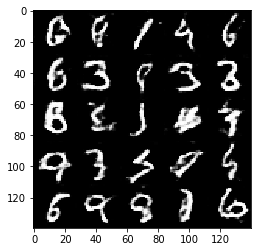

Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 0.8919
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 0.6343
Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 0.4344
Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 0.5095
Epoch 1/2... Discriminator Loss: 1.6286... Generator Loss: 0.3732
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.6427


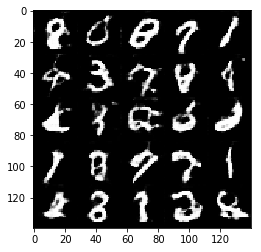

Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.6276... Generator Loss: 0.3818
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.7309... Generator Loss: 0.3395
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 1.1037
Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.5063
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 0.7541
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 1.1862


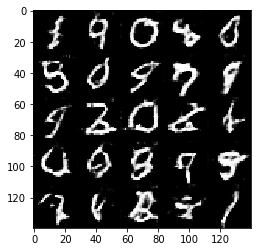

Epoch 1/2... Discriminator Loss: 1.6872... Generator Loss: 0.3558
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 0.7497
Epoch 1/2... Discriminator Loss: 2.0882... Generator Loss: 0.2213
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 0.8741... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 0.9591
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 1.4803... Generator Loss: 0.4753
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.7010


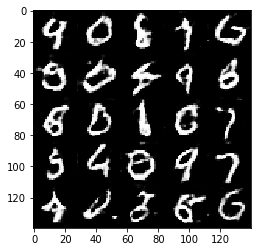

Epoch 1/2... Discriminator Loss: 1.9095... Generator Loss: 0.2944
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.4074
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 0.6274
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.4331... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.5454
Epoch 2/2... Discriminator Loss: 1.5064... Generator Loss: 0.4341
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.4760
Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 0.9846
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.5449
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.4954
Epoch 2/2.

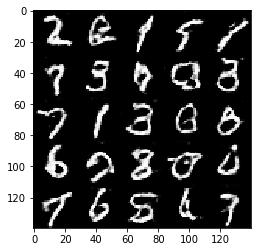

Epoch 2/2... Discriminator Loss: 1.6011... Generator Loss: 0.4147
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.5583
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.4911
Epoch 2/2... Discriminator Loss: 1.5449... Generator Loss: 0.4857
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.1048
Epoch 2/2... Discriminator Loss: 1.8994... Generator Loss: 1.6498
Epoch 2/2... Discriminator Loss: 1.6309... Generator Loss: 0.3627


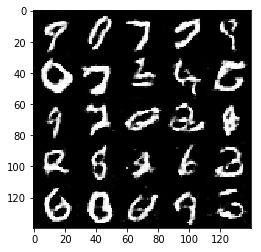

Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 1.6032
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.5088
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.6194
Epoch 2/2... Discriminator Loss: 1.4520... Generator Loss: 0.5022
Epoch 2/2... Discriminator Loss: 1.6305... Generator Loss: 0.3535
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.6207
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.5044
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 0.5168
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 0.6906


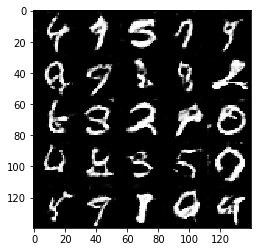

Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.6333
Epoch 2/2... Discriminator Loss: 2.3242... Generator Loss: 0.1849
Epoch 2/2... Discriminator Loss: 1.5515... Generator Loss: 0.4344
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.7983
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 0.9075
Epoch 2/2... Discriminator Loss: 1.9443... Generator Loss: 0.2925
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.5187
Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 0.6072
Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 0.9738


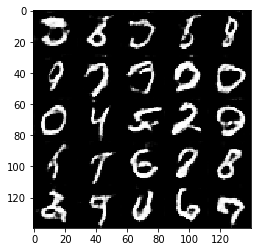

Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.5880
Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 1.1592
Epoch 2/2... Discriminator Loss: 1.8699... Generator Loss: 0.2793
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 1.0759


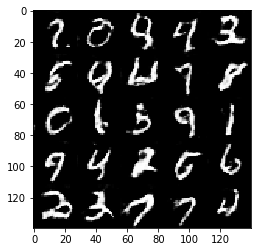

Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 0.5329
Epoch 2/2... Discriminator Loss: 1.6954... Generator Loss: 0.3750
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.9038
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 0.6645
Epoch 2/2... Discriminator Loss: 0.9796... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 1.6294... Generator Loss: 0.3932
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 0.8473
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.5101


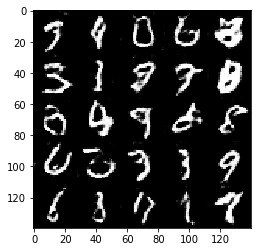

Epoch 2/2... Discriminator Loss: 1.5672... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 1.4820
Epoch 2/2... Discriminator Loss: 1.9269... Generator Loss: 0.2814
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 1.0841
Epoch 2/2... Discriminator Loss: 1.5097... Generator Loss: 0.4958
Epoch 2/2... Discriminator Loss: 1.8220... Generator Loss: 0.3700
Epoch 2/2... Discriminator Loss: 1.6151... Generator Loss: 0.4689
Epoch 2/2... Discriminator Loss: 1.6188... Generator Loss: 0.3965


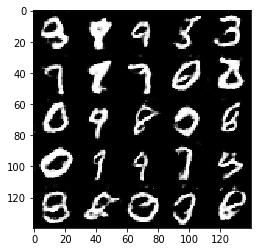

Epoch 2/2... Discriminator Loss: 1.2119... Generator Loss: 0.6103
Epoch 2/2... Discriminator Loss: 1.1684... Generator Loss: 0.6610
Epoch 2/2... Discriminator Loss: 5.1169... Generator Loss: 0.0232
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.4670
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.5457


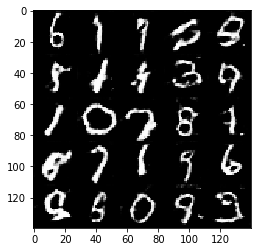

Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 1.7172
Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.1836
Epoch 2/2... Discriminator Loss: 1.4165... Generator Loss: 0.5314
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.2328
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.5704
Epoch 2/2... Discriminator Loss: 1.6750... Generator Loss: 0.3449
Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 0.8896


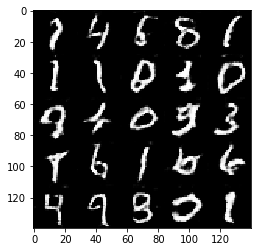

Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 2.0850... Generator Loss: 0.2595
Epoch 2/2... Discriminator Loss: 1.4577... Generator Loss: 0.4595
Epoch 2/2... Discriminator Loss: 1.4286... Generator Loss: 0.5059
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.5496
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.0599
Epoch 2/2... Discriminator Loss: 1.8636... Generator Loss: 0.3661


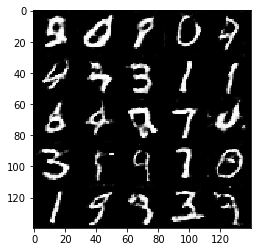

Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.5441
Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 0.6607
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 1.4494
Epoch 2/2... Discriminator Loss: 1.9847... Generator Loss: 0.2540
Epoch 2/2... Discriminator Loss: 1.3686... Generator Loss: 0.4920
Epoch 2/2... Discriminator Loss: 0.9680... Generator Loss: 0.9529
Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 1.6770... Generator Loss: 0.3768
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 0.8470


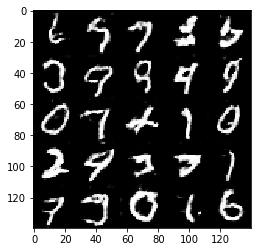

Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 1.3398
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 0.9574
Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 1.3460
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 1.4650
Epoch 2/2... Discriminator Loss: 1.6051... Generator Loss: 0.4661
Epoch 2/2... Discriminator Loss: 1.9287... Generator Loss: 0.2749
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.7168


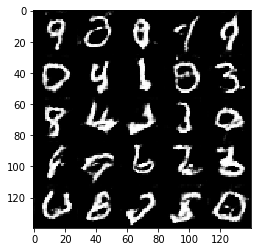

Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.4442
Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 0.7468
Epoch 2/2... Discriminator Loss: 1.6780... Generator Loss: 0.3848
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.6100
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.7941
Epoch 2/2... Discriminator Loss: 1.5485... Generator Loss: 0.4506
Epoch 2/2... Discriminator Loss: 1.0369... Generator Loss: 0.7688


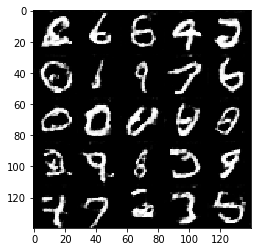

Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 0.9561
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 1.4794... Generator Loss: 0.4611
Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 0.6575
Epoch 2/2... Discriminator Loss: 1.6198... Generator Loss: 0.4628
Epoch 2/2... Discriminator Loss: 1.5994... Generator Loss: 0.4116
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.2915
Epoch 2/2... Discriminator Loss: 1.0568... Generator Loss: 1.3238
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 0.8221
Epoch 2/2... Discriminator Loss: 0.7699... Generator Loss: 1.2744


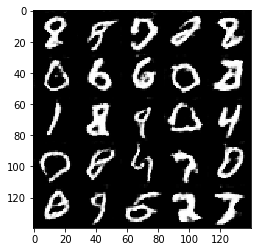

Epoch 2/2... Discriminator Loss: 1.5747... Generator Loss: 0.4598
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.6937... Generator Loss: 0.3607
Epoch 2/2... Discriminator Loss: 1.4509... Generator Loss: 0.5197
Epoch 2/2... Discriminator Loss: 0.8188... Generator Loss: 1.1197
Epoch 2/2... Discriminator Loss: 0.7681... Generator Loss: 1.4962
Epoch 2/2... Discriminator Loss: 1.9634... Generator Loss: 0.2618
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 1.5619
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.5045


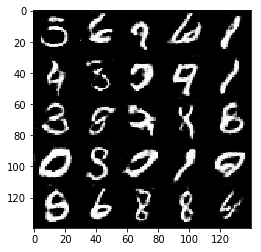

Epoch 2/2... Discriminator Loss: 1.0536... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 1.1064... Generator Loss: 2.1480
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 1.3900
Epoch 2/2... Discriminator Loss: 0.7755... Generator Loss: 1.3929
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 0.5557
Epoch 2/2... Discriminator Loss: 1.2470... Generator Loss: 0.5745


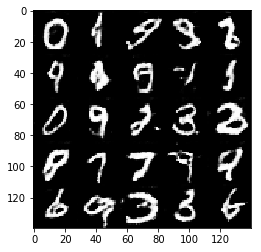

Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.6314
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 0.7603
Epoch 2/2... Discriminator Loss: 1.9793... Generator Loss: 0.2893
Epoch 2/2... Discriminator Loss: 1.2644... Generator Loss: 0.5999
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.2051... Generator Loss: 0.6463
Epoch 2/2... Discriminator Loss: 1.1570... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.6857


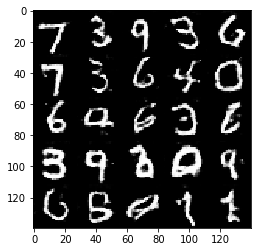

Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 0.9738
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.5314
Epoch 2/2... Discriminator Loss: 1.9765... Generator Loss: 0.2979
Epoch 2/2... Discriminator Loss: 1.1901... Generator Loss: 0.6308
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 1.1321
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.2956
Epoch 2/2... Discriminator Loss: 1.1063... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.6774... Generator Loss: 0.4384
Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 0.9321


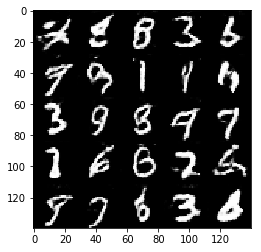

Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 1.5091
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 1.7532
Epoch 2/2... Discriminator Loss: 1.1086... Generator Loss: 0.7561
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.1431
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.1362
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 1.2955
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 1.9335


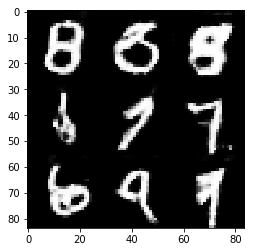

In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.8012... Generator Loss: 0.0144
Epoch 1/1... Discriminator Loss: 3.4995... Generator Loss: 0.0547
Epoch 1/1... Discriminator Loss: 2.3036... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 2.5215... Generator Loss: 0.1783
Epoch 1/1... Discriminator Loss: 2.7970... Generator Loss: 0.1050
Epoch 1/1... Discriminator Loss: 2.3596... Generator Loss: 0.2191
Epoch 1/1... Discriminator Loss: 1.8394... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 2.2185... Generator Loss: 0.2563
Epoch 1/1... Discriminator Loss: 1.9095... Generator Loss: 0.5468


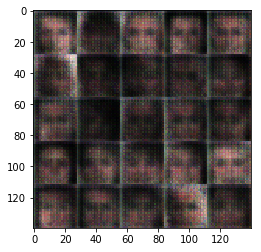

Epoch 1/1... Discriminator Loss: 1.6693... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.7382... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.8993... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.8670... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.6980... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.7413... Generator Loss: 0.3796
Epoch 1/1... Discriminator Loss: 1.7464... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 2.0967... Generator Loss: 0.2860
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.5787


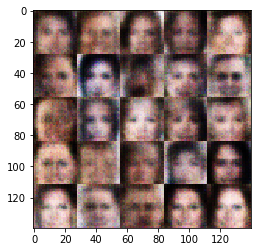

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.2390
Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 2.3440
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.8123... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 1.7543... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 1.8149... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.8233... Generator Loss: 0.3908


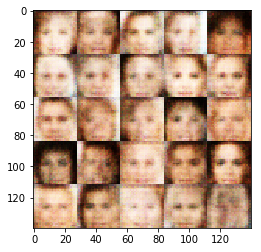

Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.8709... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.8936... Generator Loss: 0.3167
Epoch 1/1... Discriminator Loss: 1.8869... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.7090... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.6230... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.8319... Generator Loss: 0.3705
Epoch 1/1... Discriminator Loss: 1.6987... Generator Loss: 0.4235


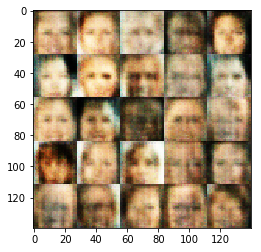

Epoch 1/1... Discriminator Loss: 1.6569... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.6405... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.8479... Generator Loss: 0.3412
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 1.1690


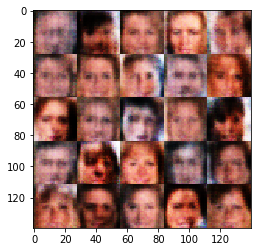

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 2.3499
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.6512... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 1.0133


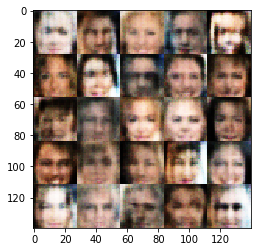

Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.6108
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 1.1192
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.0696


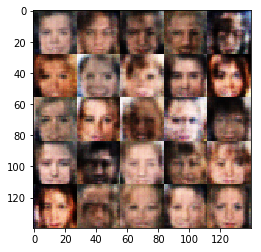

Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.7927... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8647


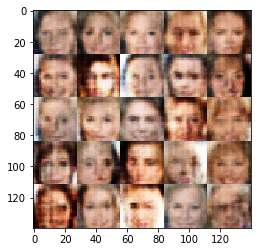

Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.6909


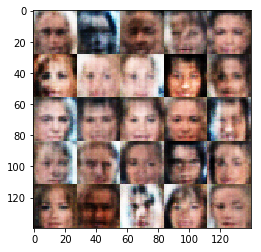

Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7276


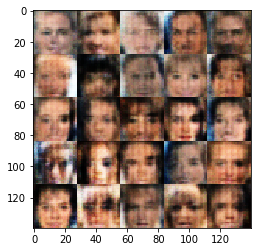

Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.7469


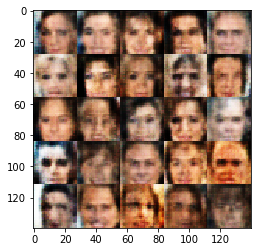

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.6481


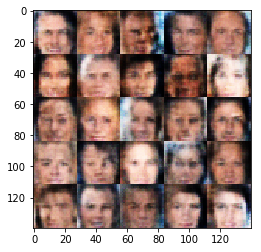

Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.7510


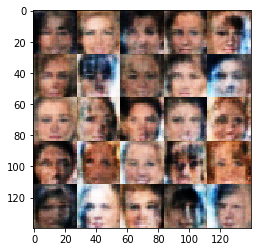

Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7328


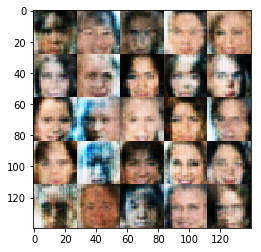

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7062


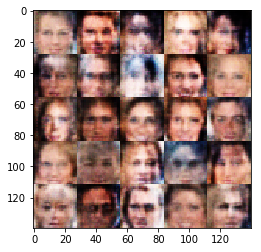

Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.6736


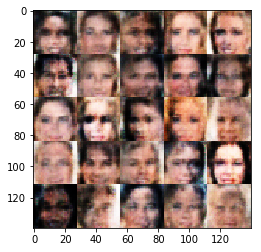

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.6984


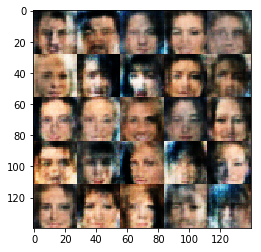

Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6797


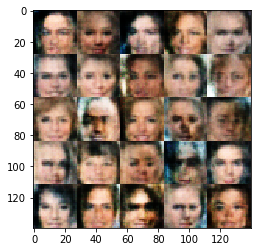

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7092


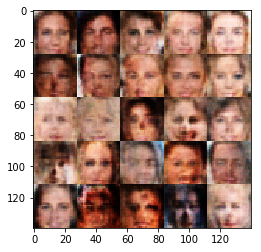

Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7049


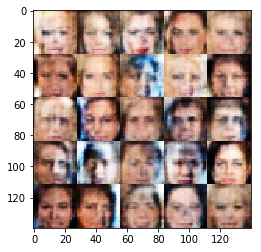

Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 1.1945


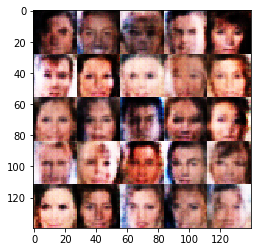

Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.6138... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7688


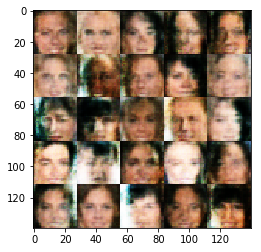

Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 2.8446... Generator Loss: 2.6205
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6788


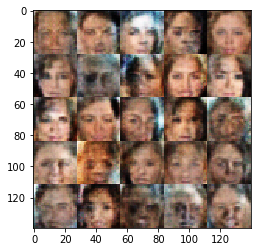

Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7781


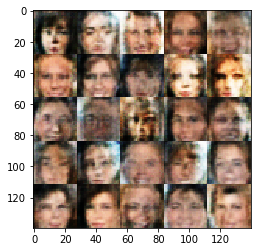

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7093


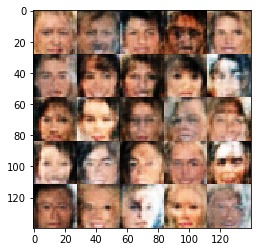

Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.6942... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.6644... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.6847


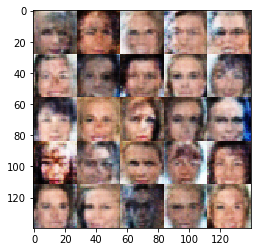

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.8317


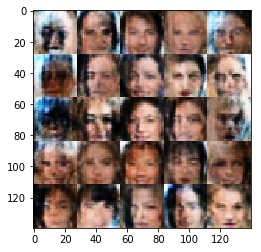

Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.3977
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.8076


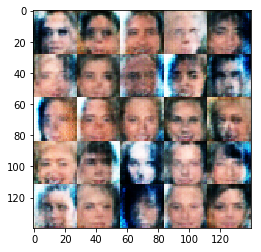

Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.6765


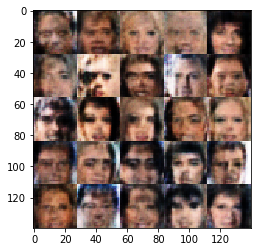

Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7473


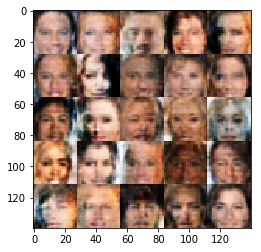

Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.6577


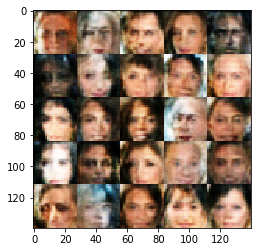

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7305


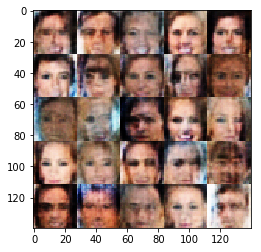

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7783


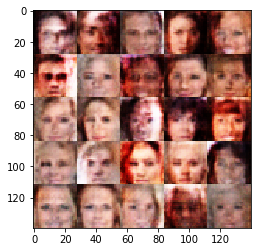

Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6500


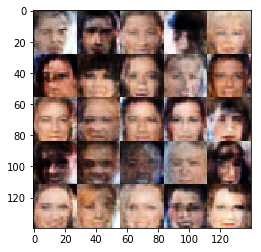

Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.3712
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6260


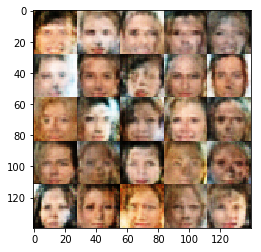

Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8112


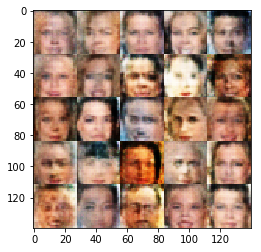

Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6722


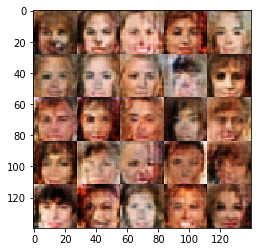

Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7474


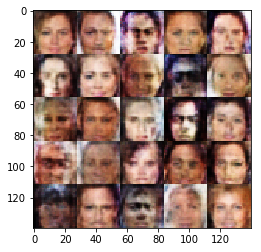

Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7605


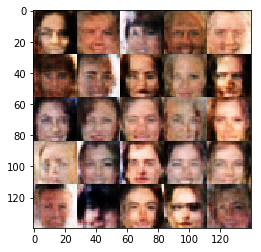

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7805


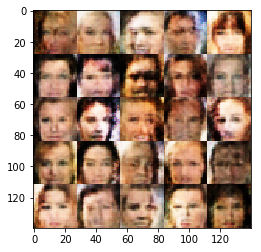

Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.7762... Generator Loss: 0.2933
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.6372


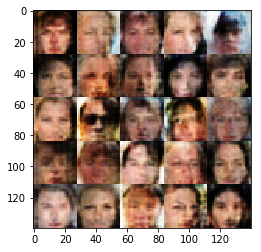

Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6438


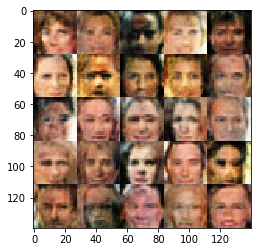

Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6281


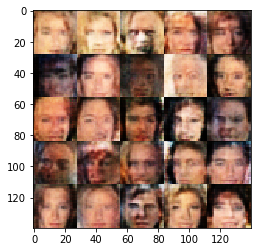

Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7815


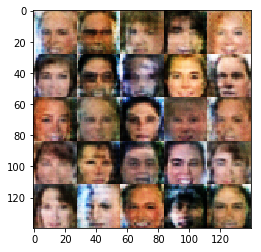

Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8145


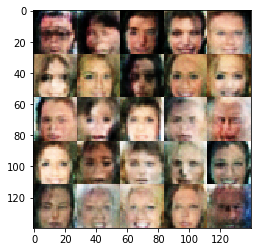

Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6504


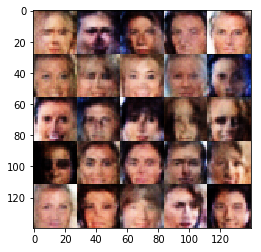

Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6051


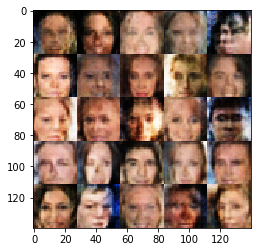

Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.7513... Generator Loss: 0.3272
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7208


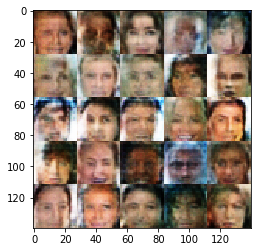

Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6143


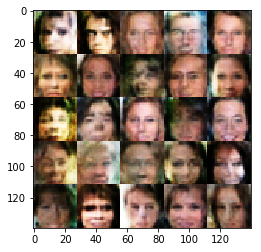

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.5430


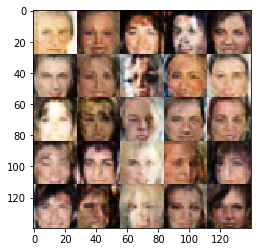

Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6424


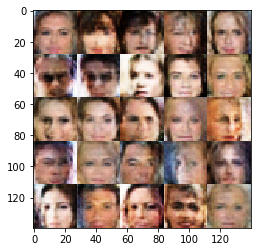

Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7110


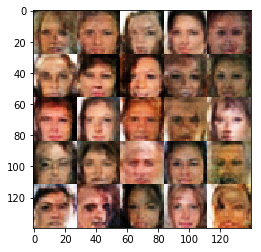

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.5949... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.9010


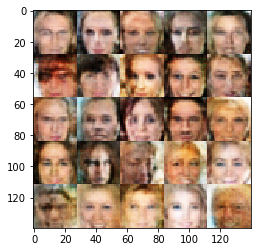

Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6189


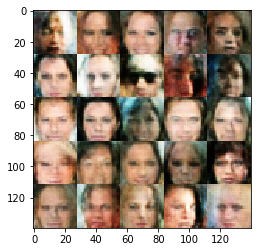

Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.8693


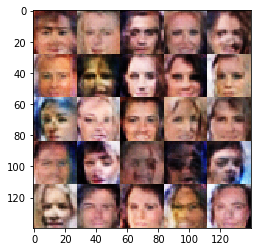

Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.8736


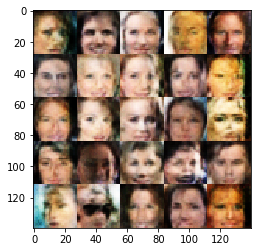

Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7136


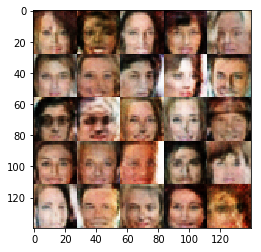

Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.7388


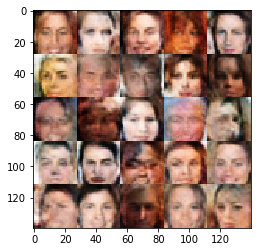

Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6050


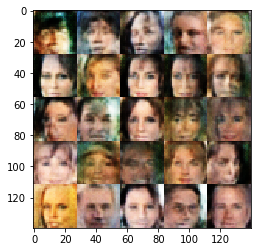

Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6241


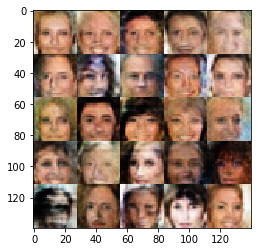

Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.6675... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6138


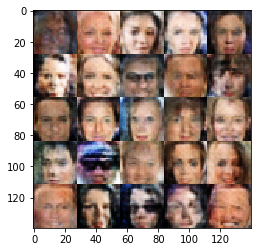

Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6088


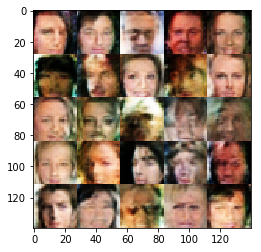

Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8976


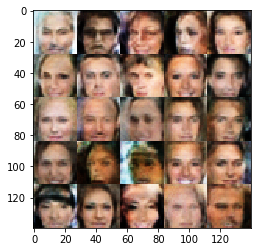

Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7446


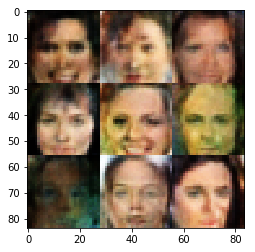

In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.